#Introduction


This project aims at evaluating the importance of transformations such as reverberation applied to the input data of a machine learning-based speech recognition system. Through the use of the *pyroomacoustics* library, we have created a toolbox to test speech recognition performances against reverberated datasets. Separately, we also implemented a real time keyword classifier based on a pretrained model.

# Speech recognition in a reverberated environment

## Review of existing techniques

Our project’s starting point was  the tutorial [1], which explains how to build a basic speech recognition network in order to differentiate the ten words ”yes”, ”no”, ”up”, ”down”, ”left”,”right”,  ”on”,  ”off”,  ”stop”,  and  ”go”.  The  tutorial  uses  the speech commands dataset, collected by google, and described in [2]. The tutorial’s algorithm is trained using the architecture described in [3], using convolutional neural networks instead of  deep  neural  networks  which  are  in  use  for  keyword  classification in current applications. This technique is very close to  building  a  network  for  image  classification,  as  the  sound is converted into a spectrogram, and this spectrogram is used as input of the network. The spectrogram represents all frequency components as a function of time, and it can be represented in 2 dimensions. The tutorial [1] uses a standard spectrogram, but actually, the human ear being more sensitive to certain frequencies than others, a better representation  for  speech  recognition would be the Mel-Frequency Cepstral Coefficients.
Other approaches to build neural networks working with audio include  recurrent  networks  or  dilated  (atrous)  convolutions.  
Pyroomacoustics  is  a  python  package  for  audio  signal  processing for indoor applications. The main function we use in the  scope  of  our  project  is  the  simulation  of  a  room  and  its impulse response. We augment the dataset [2] by convolving every input sound with different impulse responses, to obtain more data.

## Algorithm description

When developing tools for the project, all the code has been written in object-oriented paradigm in order to create an easily adaptable toolbox to test several configurations for the speech recognition framework. This toolbox was based on the already existing \textit{pyroomacoustics} Python library to work in conjunction with the Google Speech Commands Dataset. The speech recognition system is a machine learning-based speech recognition system from the TensorFlow library.


**Choice of the dataset**

To train the speech recognition system, we have to define a speech dataset. We chose the Google Speech Commands Dataset, which consists of 105,000 .wav audio files of people saying thirty different words. This dataset is very interesting both for its size and diversity.


As it is a collection of user-contributed audio files, words are pronounced by several different speakers and in various environments. This is interesting to note that the recording conditions differ according to the users that recorded it, and that they represent various living rooms in which a speech recognition system could be used.


**Dataset transformation**

We load the dataset thanks to the \textit{pyroomacoustics} Google Speech dataset wrapper. It allows us to get a dataset object from the directory where we stored the dataset. The dataset object is a convenient way to manipulate the whole dataset. Once it is loaded, we can access each sample and its corresponding label, as well as the path where it is stored.


The dataset transformation consists of two scripts : 
- the 'speech_dataset_load.py' script that loads all the samples and labels into a dataset object
- the 'reverb_data.py' script that creates a copy of the whole dataset and that applies a reverberation algorithm to each individual sample but maintains the original label of the sample

At the beginning of the 'speech_dataset_load' script we load the Speech Dataset locally. There is no trick on this part of the project since it consists in a simple utilisation of the pyroomacoustics library. Let us note that the dataset also contains noise samples that are mixed with the speech samples during the training process in order to obtain a more robust speech recognition model in the end.


In [0]:
def load_speech_dataset(subset, playsound=False, noplot=True):

    parser = argparse.ArgumentParser(description='Example of using the GoogleSpeechCommands wrapper')
    parser.add_argument('--noplot', action='store_true',
            help='Do not display any plot')
    parser.add_argument('--playsound', action='store_true',
            help='Play one example sentence')
    args = parser.parse_args()

    # create a subset of the Google Speech Commands dataset that contains 10 of each word and the noise samples
    data_path = '/tensorflow-master/tensorflow/examples/speech_commands/data'
    dataset = pra.datasets.GoogleSpeechCommands(basedir= os.getcwd() + '/' + data_path, download=False, subset=subset)

    # print dataset info and first 10 entries
    print(dataset)
    print()
    dataset.head(n=10)

    # separate the noise and the speech samples
    print()
    noise_samps = dataset.filter(speech=0)
    print("Number of noise samples : %d" % len(noise_samps))
    speech_samps = dataset.filter(speech=1)
    print("Number of speech samples : %d" % len(speech_samps))

    # print info of first speech sample
    print()
    print(speech_samps[0])

    # list sounds in our dataset and number of occurences
    print()
    print("All sounds in the dataset:")
    print(dataset.classes)

    # filter by specific word
    selected_word = dataset.classes[1]
    matches = speech_samps.filter(word=selected_word)
    print()
    print("Number of '%s' samples : %d" % (selected_word, len(matches)))

    # play sound
    if playsound:
        matches[0].play()

    # show the spectrogram
    if not noplot:
        import matplotlib.pyplot as plt

        plt.figure()
        matches[0].plot()

        plt.show()

    return dataset

For the 'reverb_data.py' script, we first load the whole dataset by calling the *load_dataset* function. Then, we create two entities with the function *separate_dataset* : one for the noise samples that will just be copied, and one for the speech samples that will be transformed with reverberation. In parallel, the data directory structure is copied in order to keep the label information for each speech sample in *init_new_folder*.

In [0]:
def load_dataset(self, subset=10):
    """
    Calls the load_speech_dataset function that creates a Dataset object from the GSD.
    """
    print('Loading the Google Speech Dataset.')
    print()
    self.raw_dataset = load_speech_dataset(subset)
    print('Google Speech Dataset successfully loaded.')
    print()

def separate_dataset(self):
    """
    Separates the dataset into speech/noise.
    """
    print('Separate dataset between speech and noise :')
    self.raw_only_speech = self.raw_dataset.filter(speech=True)
    self.raw_only_noise = self.raw_dataset.filter(speech=False)
    print('Successfully separated the dataset.')

def init_new_folder(self, new_name):
    """
    This method creates and initiates the subfolders containing each wav file.
    """
    self.new_folder_name = new_name
    self.new_path = re.sub('data', self.new_folder_name, self.raw_dataset.basedir)

    print('The new folder is located at : {0}'.format(self.new_path))
    if not os.path.isdir(self.new_path):
        os.makedirs(self.new_path)

    for subdir in self.raw_dataset.subdirs:
        extracted_subdir = re.split('/', subdir)[-2]
        # We do not want to apply reverb on the background noise folder,
        # so we exclude this folder during this step
        if extracted_subdir != '_background_noise_':
            if not os.path.exists(self.new_path + '/' + extracted_subdir):
                os.makedirs(self.new_path + '/' + extracted_subdir)

    print('New Folder initiated.')

After this initial phase, we simply apply reverberation to every sample in the *dataset* object. For each sample, we retrieve the audio file, create a reverberation model from the class *ReverbModel* and apply the reverberation transformation to this sample.

In [0]:
def init_reverb_model(self):
    """
    Inits the reverberation model to be applied
    """
    self.reverb_model = reverb_model.ReverbModel()
    self.reverb_model.reverb_model1()

def apply_reverb(self):
    """
    Applies reverberation to all the samples in the dataset
    """
    print('Applying reverberation algorithm to the whole dataset : ')

    for idx_sample, sample in enumerate(self.raw_only_speech):
        self.init_reverb_model()
        audio_sample_no_rev = sample.data
        output_path = re.sub('data', self.new_folder_name, sample.meta.file_loc)
        self.reverb_model.transform_audio(audio_sample_no_rev, output_path)

        if (idx_sample % 500 == 0) and (idx_sample > 0):
            print('Now treating sample {0}.'.format(idx_sample))

    print('Reverberation applied to the whole speech dataset.')

Below is a part of the *ReverbModel* class :
- *reverb_model1* is one of the methods creating a reverberation model
- transform_audio simply takes the reverberation model, the input audio as a source, and the signal captated from the microphone as the output

In [0]:
def reverb_model1(self, absorption = 0.2, max_order = 15):
    self.room_dimensions = [6, 5, 7]
    self.absorption = absorption
    self.max_order = max_order
    self.fs = 16000

    self.shoebox = pra.ShoeBox(
        self.room_dimensions,
        absorption=self.absorption,
        fs=self.fs,
        max_order=self.max_order,
    )

    self.source_position = [2, 3.1, 2]
    self.mic = pra.MicrophoneArray(np.array([[2, 1.5, 2]]).T, self.shoebox.fs)   

def transform_audio(self, audio_sample, output_path):
    """
    Applies reverberation to the audio_sample.
    The source in the virtual room plays the audio_sample signal.
    The output is the result of the captation of the microphone in the virtual room.
    :param audio_sample: data signal we want to apply reverb on
    :param output_path: path where we want to store the output of the reverberation algorithm
    """
    self.shoebox.add_source(self.source_position, signal=audio_sample)
    self.shoebox.add_microphone_array(self.mic)

    self.shoebox.simulate()
    self.shoebox.mic_array.to_wav(output_path, norm=True, bitdepth=np.int16)

For the reverberation model, we have taken simple models : rectangular rooms (shoeboxes) with one source and one microphone. As stated above, the source is playing the input audio, and the output audio is the signal captated from the microphone.

The taken parameters where typical of listening conditions in a big room : 
- absorption coefficient between 0.1 and 0.2
- dimensions around 5 meters
- source and microphones placed in the room, not to close to the walls

In total, we have 4 reverberation models ranging to the least reverberating one to the most reverberating one.

At the end of the process, we write the output file in the new folder containing all the reverberated samples.

**Mixed Reverberation model**

The above part details the process of transforming the original dataset into a new dataset where every sample is reverberated. For each sample we took the same reverberation model.
One way to explore improvements to the original speech recognition model is to change the reverberation parameters for each sample. Instead of having one reverberation model for each sample, we have an ensemble of reverberation parameters from which we choose one for each sample randomly.

In [0]:
def init_random_reverb_model(self):
    """
    Init the reverberation randomly among the choices in param
    """
    params = random.choice(self.random_params)

    self.reverb_model = reverb_model.ReverbModel()
    self.reverb_model.reverb_model_generic(params[0], params[1], params[2])

def apply_reverb_random(self, set_params):
    """
    Applies reverberation to all the samples in the dataset.
    For each sample, a random reverberation model is chosen among all the parameters given.
    :param set_params: the set of parameters to choose from for the reverberation model.
    """
    print('Applying reverberation to the whole dataset with randomized parameters.')
    self.random_params = set_params

    for idx_sample, sample in enumerate(self.raw_only_speech):
        self.init_random_reverb_model()
        audio_sample_no_rev = sample.data
        output_path = re.sub('data', self.new_folder_name, sample.meta.file_loc)
        self.reverb_model.transform_audio(audio_sample_no_rev, output_path)

        if (idx_sample % 500 == 0) and (idx_sample > 0):
            print('Now treating sample {0}.'.format(idx_sample))

    print('Reverberation applied to the whole speech dataset.')

This acted as a fifth reverberated dataset, being a mix of multiple reverberation models.

In total, we had :
- the dry model (the original Google Speech Dataset)
- 4 reverberated models
- the mixed parameters model

**Training the model with reverberated dataset**

The training part was performed using *TensorFlow* implementation. The part we changed is the input data we give to the algorithm to process. The command below was used to train the *TensorFlow* model.

We used the script *train.py* from the Audio Recognition *TensorFlow* GitHub.

Let us note that we had to use clusters provided by EPFL to run this part : first trainings took more thant 15 hours on our laptops, as it consists of 18 000 training steps, which corresponds to a huge training process. By using cluster computers, it took less than 4 hours and we were able to run multiple training instances simultaneously.

## Testing the performances of the model

Here we detail the way we test the performances of the trained models in the *test_model* script.

Once we have trained the speech recognition model with our data, be it the original one, or a reverberated one, we obtain a .pb graph representing our final trained model. With this graph we are able to test the model on validation files.

Validation files are files that we did not use during training, and we kept only to test the final model in the end. For each one, we run the script *label_wav* (based on the *TensorFlow* project implementation) that outputs the scores for each label between 0 and 1.

Given a sample and a graph, we thus obtain a score giving the prediction that the model gives on each label. We then average the prediction accuracy for each true label on a set of validation files.

In [0]:
    def label_wav(self, wav, labels, graph, input_name, output_name, how_many_labels):
        """Loads the model and labels, and runs the inference to print predictions."""
        if not wav or not tf.io.gfile.exists(wav):
            tf.compat.v1.logging.fatal('Audio file does not exist %s', wav)

        if not labels or not tf.io.gfile.exists(labels):
            tf.compat.v1.logging.fatal('Labels file does not exist %s', labels)

        if not graph or not tf.io.gfile.exists(graph):
            tf.compat.v1.logging.fatal('Graph file does not exist %s', graph)

        labels_list = self.load_labels(labels)

        # load graph, which is stored in the default session
        self.load_graph(graph)

        with open(wav, 'rb') as wav_file:
            wav_data = wav_file.read()

        return self.run_graph(wav_data, labels_list, input_name, output_name, how_many_labels)

We then encompass this function in a bigger one that runs the tests and stores the results. We test each model on each dataset (non-reverberated and reverberated ones).

In [0]:
    def test_model(self, model_number):
        self.graph_model_path = self.base_path + '/../results/frozen_graph_set' + str(model_number) + '.pb'
        self.conv_labels_path = self.base_path + '/../results/conv_labels.txt'
        self.scores = np.zeros(subset)

        print('Starting test for model {0}'.format(model_number))

        list_indices = range(len(self.list_paths))
        sublist_indices = random.choices(list_indices,k=self.subset)


        for id, index_sample in enumerate(sublist_indices):

            if id % 50 == 0:
                print('Currently at sample {0}'.format(id))

            self.current_label = self.list_labels[index_sample]
            self.scores[id] = self.label_wav(self.base_path + '/' + self.list_paths[index_sample],
                                             self.conv_labels_path,
                                                       self.graph_model_path, 'wav_data:0', 'labels_softmax:0',
                                                       self.how_many_labels)
        print('Test for model {0} done.'.format(model_number))
        print()

    def test_all_models(self, list_models):

        self.all_scores = np.zeros(len(list_models))
        self.full_scores = np.zeros((len(list_models), self.subset))
        path_to_save_scores = self.base_path + '/../results/scores_' + self.data_name + '.npy'
        path_to_save_full = self.base_path + '/../results/full_' + self.data_name + '.npy'
        random.seed(42)

        for index_model, model in enumerate(list_models):
            self.test_model(model)
            self.full_scores[index_model, :] = self.scores
            self.all_scores[index_model] = np.average(self.scores)

        np.save(path_to_save_scores, self.all_scores)
        np.save(path_to_save_full, self.full_scores)


#Real Time Implementation

The real time implementation was done using the python sounddevice library. In the original tutorial [1], there was already a C++ implementation of real time keyword classification, but it did not accept microphone inputs: it could recognise where the keywords were spoken from a long audio file, in real time. The way this algorithm worked was by applying many times the model, with a lot of different time offsets and averaging the results. This is because the words we want to recognize can start at any time, so we need to take a series of snapshots to have a chance of having an alignment that captures most of the utterance in the time window we feed into the model. If we sample at a high enough rate, then we have a good chance of capturing the word in multiple windows, so averaging the results improves the overall confidence of the prediction.  
After getting used to the sounddevice and tensorflow libraries, the main problem we faced to implement such an algorithm in python was the fact that it is not possible to convert the sound input directly into 16 bit linear pulse code modulation format, which is the format of the input to the tensorflow graph, without changing the soundfile library. Therefore we found a way to work around this problem by saving a .wav file and reading it again, every second. Since this process considerably slows down the program, it is not possible to perform window averaging as suggested by the tutorial's C++ implementation. However, good results can already be observed with this implementation. The algorithm also plots the input on which the prediction is being made, at every second.  
This is the main file to call to have the real-time classification, it is called real_time.py on our github. It was adapted from an example on the sounddevice library site [4], which already plotted the input in real-time. We call our classification function in update_plot, in order to classify in real_time every window that is plotted. Notice that we have to write and read a wav file in order to feed the correct format to the graph.

In [0]:
"""Plot the live microphone signal(s) with matplotlib, and classifies the word spoken out of 10 known keywords

Matplotlib and NumPy have to be installed.
This was adapted from an example given on sounddevice. """


import argparse
import queue
import sys

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
import scipy.io.wavfile as wavconv
import soundfile as sf

from label_wav_realtime import *


def int_or_str(text):
    """Helper function for argument parsing."""
    try:
        return int(text)
    except ValueError:
        return text


parser = argparse.ArgumentParser(add_help=False)
parser.add_argument(
    '-l', '--list-devices', action='store_true',
    help='show list of audio devices and exit')
args, remaining = parser.parse_known_args()
if args.list_devices:
    print(sd.query_devices())
    parser.exit(0)
parser = argparse.ArgumentParser(
    description=__doc__,
    formatter_class=argparse.RawDescriptionHelpFormatter,
    parents=[parser])
parser.add_argument(
    'channels', type=int, default=[1], nargs='*', metavar='CHANNEL',
    help='input channels to plot (default: the first)')
parser.add_argument(
    '-d', '--device', type=int_or_str,
    help='input device (numeric ID or substring)')
parser.add_argument(
    '-w', '--window', type=float, default=1000, metavar='DURATION',
    help='visible time slot (default: %(default)s ms)')
parser.add_argument(
    '-i', '--interval', type=float, default=30,
    help='minimum time between plot updates (default: %(default)s ms)')
parser.add_argument(
    '-b', '--blocksize', type=int, help='block size (in samples)')
parser.add_argument(
    '-r', '--samplerate', type=float, help='sampling rate of audio device')
parser.add_argument(
    '-n', '--downsample', type=int, default=1, metavar='N',
    help='display every Nth sample (default: %(default)s)')
args = parser.parse_args(remaining)
if any(c < 1 for c in args.channels):
    parser.error('argument CHANNEL: must be >= 1')
mapping = [c - 1 for c in args.channels]  # Channel numbers start with 1
q = queue.Queue()


def audio_callback(indata, frames, time, status):
    """This is called (from a separate thread) for each audio block."""
    if status:
        print(status, file=sys.stderr)
    # Fancy indexing with mapping creates a (necessary!) copy:
    q.put(indata[::args.downsample, mapping])


def update_plot(frame):
    """This is called by matplotlib for each plot update.

    Typically, audio callbacks happen more frequently than plot updates,
    therefore the queue tends to contain multiple blocks of audio data.

    """
    global i
    i=i+1
    global plotdata
    while True:
        try:
            data = q.get_nowait()
        except queue.Empty:
            break
        shift = len(data)
        plotdata = np.roll(plotdata, -shift, axis=0)
        plotdata[-shift:, :] = data

    sf.write('wavfile.wav', plotdata, 16000, subtype='PCM_16',format='wav')
    with open('wavfile.wav', 'rb') as wav_file:
        bitdata = wav_file.read()
    label = label_wav(bitdata, 'conv_labels.txt', 'first_model_graph_anechoic.pb')
    if label[0] != 0:
        print(label)

    print(i)

    for column, line in enumerate(lines):
        line.set_ydata(plotdata[:, column])
    return lines


try:

    args.samplerate=16000

    length = int(args.window * args.samplerate / (1000 * args.downsample))
    plotdata = np.zeros((length, len(args.channels)))

    fig, ax = plt.subplots()
    lines = ax.plot(plotdata)
    if len(args.channels) > 1:
        ax.legend(['channel {}'.format(c) for c in args.channels],
                  loc='lower left', ncol=len(args.channels))
    ax.axis((0, len(plotdata), -1, 1))
    ax.set_yticks([0])
    ax.yaxis.grid(True)
    ax.tick_params(bottom=False, top=False, labelbottom=False,
                   right=False, left=False, labelleft=False)
    fig.tight_layout(pad=0)

    stream = sd.InputStream(
        device=args.device, channels=max(args.channels),
        samplerate=args.samplerate, callback=audio_callback)
    i=0
    ani = FuncAnimation(fig, update_plot, interval=1000, blit=True)
    with stream:
        plt.show()
except Exception as e:
    parser.exit(type(e).__name__ + ': ' + str(e))


In this second file, called label_wav_realtime.py on our github, we load a pretrained tensorflow graph and make it predict on the data from the wav file.

In [0]:
def load_graph(filename):
  """Unpersists graph from file as default graph."""
  with tf.io.gfile.GFile(filename, 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')


def load_labels(filename):
  """Read in labels, one label per line."""
  return [line.rstrip() for line in tf.io.gfile.GFile(filename)]


def run_graph(wav_data, labels, input_layer_name, output_layer_name,
              num_top_predictions):
  """Runs the audio data through the graph and prints predictions."""
  with tf.compat.v1.Session() as sess:
    # Feed the audio data as input to the graph.
    #   predictions  will contain a two-dimensional array, where one
    #   dimension represents the input image count, and the other has
    #   predictions per class
    softmax_tensor = sess.graph.get_tensor_by_name(output_layer_name)
    predictions, = sess.run(softmax_tensor, {input_layer_name: wav_data})

    # Sort to show labels in order of confidence
    top_k = predictions.argsort()[-num_top_predictions:][::-1]

    for node_id in top_k:
      human_string = labels[node_id]
      score = predictions[node_id]
      print('%s (score = %.5f)' % (human_string, score))
    return top_k


def label_wav(wav_data, labels, graph, input_name='wav_data:0', output_name='labels_softmax:0', how_many_labels=3):
  """Loads the model and labels, and runs the inference to print predictions."""

  if not labels or not tf.io.gfile.exists(labels):
    tf.compat.v1.logging.fatal('Labels file does not exist %s', labels)

  if not graph or not tf.io.gfile.exists(graph):
    tf.compat.v1.logging.fatal('Graph file does not exist %s', graph)

  labels_list = load_labels(labels)

  # load graph, which is stored in the default session
  load_graph(graph)

  return run_graph(wav_data, labels_list, input_name, output_name, how_many_labels)

This real time implementation could allow us to adapt a keyword classifier to a certain room, by choosing weights trained with a room similar to the one we are in. 

# Results and discussion

Scores of dry model:

|        | anechoic | reverb 1 | reverb 2 | reverb 3 | reverb 4 | mixed models |
|--------|----------|----------|----------|----------|----------|--------------|
| scores | 72.6% | 77.2% |  70.7% | 74.9%  |  72.3% | 72.4%    |


Scores of model 1: 


|        | anechoic | reverb 1 | reverb 2 | reverb 3 | reverb 4 | mixed models |
|--------|----------|----------|----------|----------|----------|--------------|
| scores | 69.1%  | 73.0% | 67.3% | 71.3% | 70.8% |  69.5%   |

Scores of model 2:

|        | anechoic | reverb 1 | reverb 2 | reverb 3 | reverb 4 | mixed models |
|--------|----------|----------|----------|----------|----------|--------------|
| scores | 63.8% | 68.7% | 61.6% | 66.8% | 67.0% | 64.7%    |

Scores of model 3:

|        | anechoic | reverb 1 | reverb 2 | reverb 3 | reverb 4 | mixed models |
|--------|----------|----------|----------|----------|----------|--------------|
| scores | 65.3% | 70.6% |64.7% | 68.1% | 65.0% |  66.8%   |

Scores of model 4:


|        | anechoic | reverb 1 | reverb 2 | reverb 3 | reverb 4 | mixed models |
|--------|----------|----------|----------|----------|----------|--------------|
| scores | 66.2% | 74.6%| 66.6% | 71.1% |  69.1%| 69.0%   |



Scores of mixed reverb model:


|        | anechoic | reverb 1 | reverb 2 | reverb 3 | reverb 4 | mixed models |
|--------|----------|----------|----------|----------|----------|--------------|
| scores | 66.1%| 70.6%| 66.2% | 69.9% | 69.5% |67.2%   |





The scores displayed above are the means of the scores given by the model at its output layer. The scores represent how confident the model is in its prediction. The final score is the mean of the scores over 200 samples for each dataset. For classification, the label corresponding to the highest score is the prediction.  
Our first expectation was that we would obtain better results in the tests if the test was processed in the same way as the training data. It is interesting to see that this is not the case for all our models: it is only true for model 1. In fact, in the case of model 2, it is even the dataset that is the least well predicted.  
One interesting result is also that the model trained on dry data is by far better than the other models, for all testing datasets. This result is a little bit disappointing as it means we have failed to improve the algorithm's performances by augmenting the dataset.  
We had also expected to see a ranking of the different models according to the "amount of reverberation" that we had put in every model, unfortunately we do not really see such a behaviour in our results: model 1 has much better scores than model 2, but model 4 has scores which are very close to model 1.
We might explain those surprising results by the fact that the original dry dataset is actually not fully dry, but includes a lot of different impulse responses, since the data comes from recordings people have made in their home. The original dataset might actually be a lot more diverse in terms of impulse responses than what we created artificially, which had 4 different impulse responses at most, and therefore gives better results. 


means of datasets [0.67174293 0.72436887 0.66195467 0.70367413 0.68924375 0.68263217]
means of models [0.73346819 0.70163054 0.65432334 0.66759061 0.69430006 0.68230376]


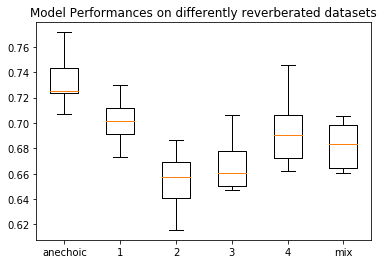

In [0]:
import numpy as np
import matplotlib.pyplot as plt

results= [[0.72592986, 0.77158651, 0.70728204, 0.74885913, 0.72304554, 0.72410606],
[0.69062885, 0.7299644,  0.67326452, 0.71344629, 0.70770812, 0.69477109],
[0.6381686,  0.6868683,  0.61563976, 0.66805035, 0.66979465, 0.6474184 ],
[0.65324595, 0.70628374 ,0.6472106 , 0.68137294, 0.64950378 ,0.66792668],
[0.66174808, 0.74576864, 0.66628282 ,0.71110665, 0.69089016, 0.69000403],
[0.66073624, 0.7057416,  0.66204827, 0.6992094,  0.69452024, 0.67156678]]

#means according to the dataset
print('means of datasets', np.mean(results,axis=0))

#means according to the model
print('means of models', np.mean(results,axis=1))

plt.boxplot(results,labels=('anechoic','1','2','3','4','mix'))
plt.title('Model Performances on differently reverberated datasets')
plt.show()


# Conclusion

In this project, we implemented a real time keyword classifier using the sounddevice library, and we augmented the google speech commands dataset with the pyroomacoustics library to train a more robust keyword classifier. Results we obtained were not the ones we expected, but they were relevant nevertheless.

Bibliography:  
[1]:https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/sequences/audio_recognition.md

[2]:Speech commands: A dataset for limited-vocabulary speech recognition, Warden,Pete 2018

[3]:Convolutional neural networks for small-footprint keyword spotting, Sainath 2015  
[4]:https://python-sounddevice.readthedocs.io/en/0.3.14/